In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from keras.layers import Dropout
from keras.models import Model

In [3]:
import zipfile
local_zip = '/content/drive/MyDrive/Adamata-MLintern/dataset-resized.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
Lok = '/tmp/dataset-resized/'

In [5]:
os.listdir('/tmp/dataset-resized/')

['test', 'train']

# 2. Image Acquistion

In [6]:
kelas = []
n_gmbar = []
data = {'JenisSampah':[], 'Jumlah':[]}

for i in os.listdir(Lok+'/train'):
    n_gmbar.append(len(os.listdir(Lok+'/train/'+i)))
    kelas.append(i)

data['JenisSampah']+=kelas
data['Jumlah']+=n_gmbar

df = pd.DataFrame(data)
df

,JenisSampah,Jumlah
0,trash,130
1,metal,328
2,paper,475
3,glass,400
4,plastic,385
5,cardboard,322


<Axes: xlabel='JenisSampah', ylabel='Jumlah'>

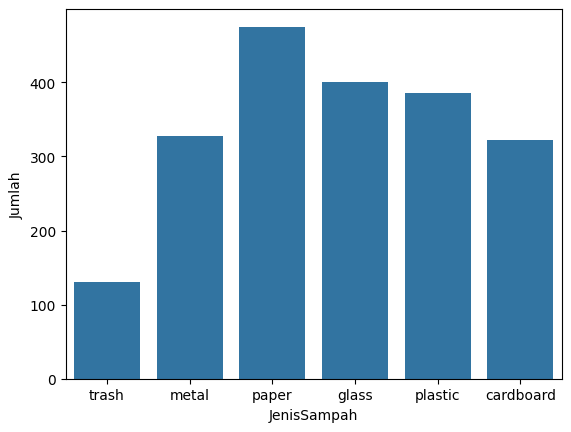

In [7]:
sns.barplot(x=df['JenisSampah'], y=df['Jumlah'])

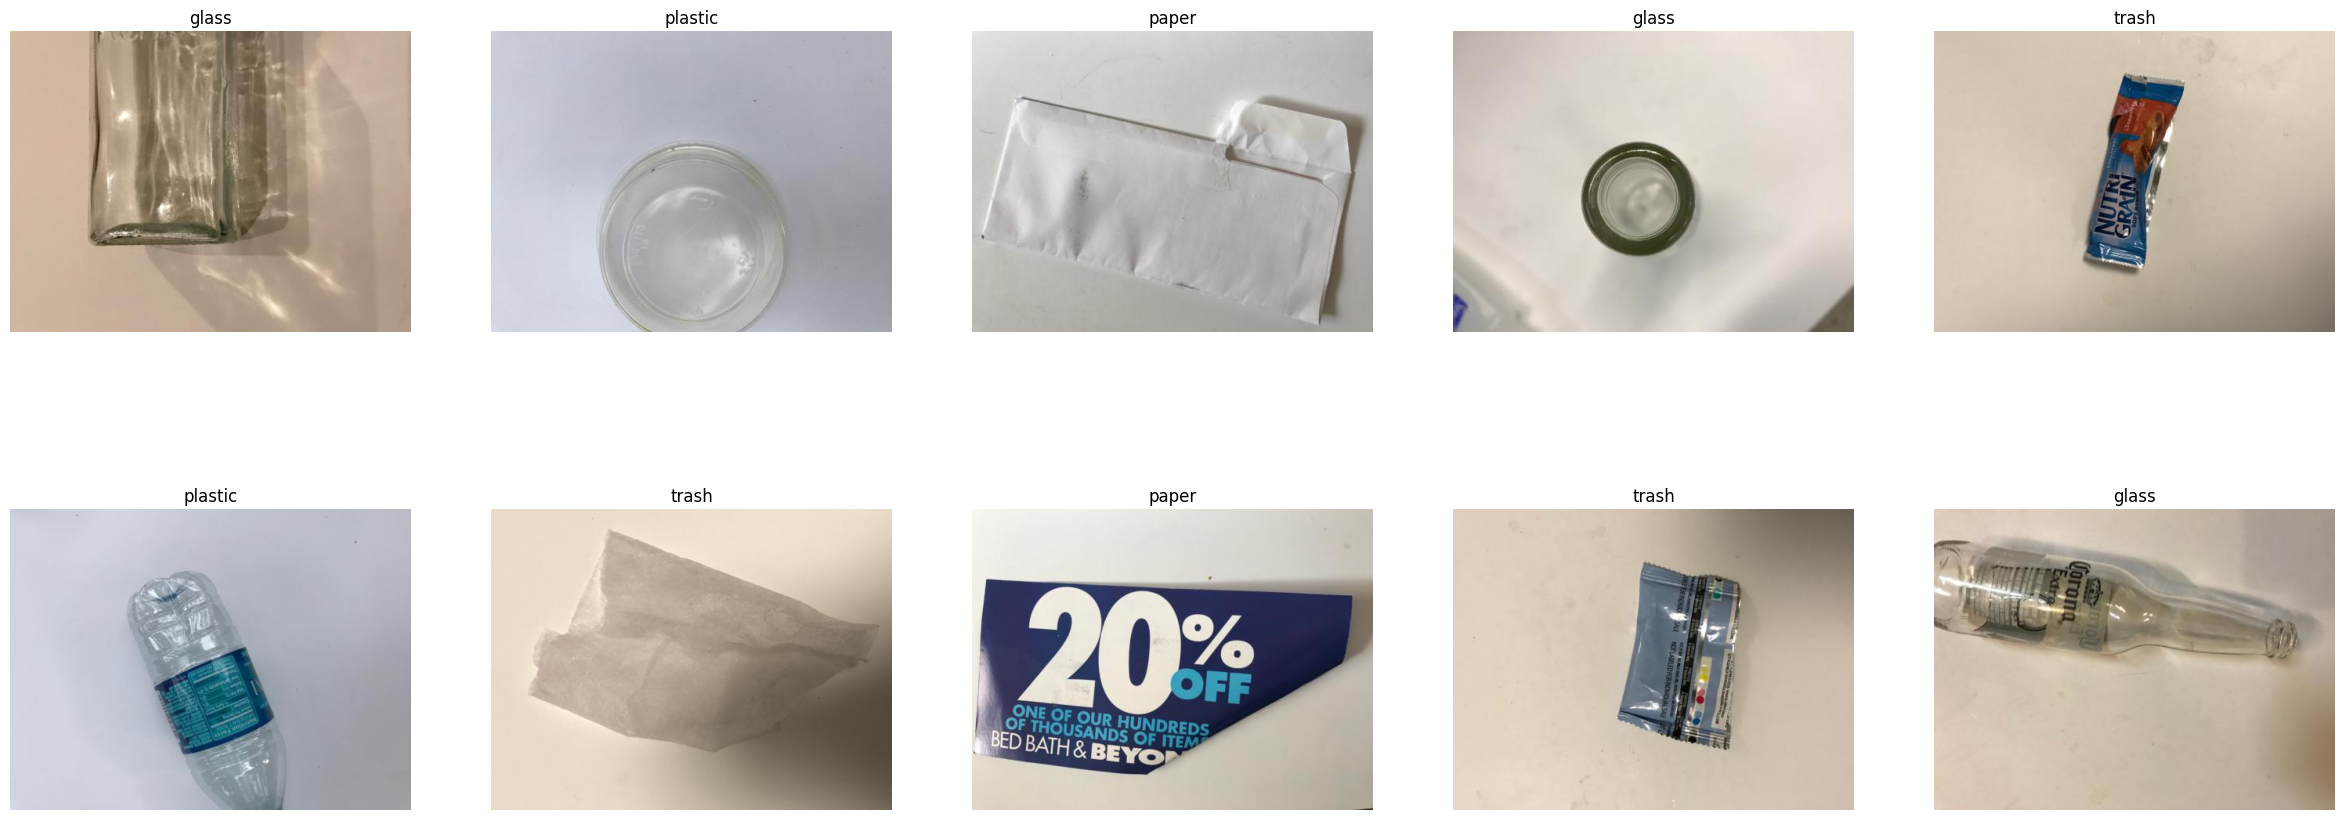

In [8]:
dataSampah = os.listdir(Lok+'/train')

plt.figure(figsize=(30,30))
for x in range(10):
    i       = random.randint(0,4)  #mengambbil gambar dari 3 folder
    NamaKls = os.listdir(Lok+'/train'+'/'+dataSampah[i])

    j          = random.randint(0,100)
    gmbr       = cv2.imread(Lok+'/train'+'/'+dataSampah[i]+'/'+NamaKls[j])
    gmbr       = cv2.cvtColor(gmbr, cv2.COLOR_BGR2RGB)
    ax         = plt.subplot(5, 5, x+1)
    plt.imshow(gmbr)
    plt.title(dataSampah[i])
    plt.axis("off")

plt.show()

# 3. Pre-processing

In [9]:
image_datagen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                               rotation_range=40,
                                                               shear_range=0.2,
                                                              zoom_range=0.2,
                                                              width_shift_range=0.2,
                                                              height_shift_range=0.2,
                                                              horizontal_flip=True,
                                                              validation_split=0.2)

In [10]:
train_ds = image_datagen.flow_from_directory(Lok+'/train',
                                            subset='training',
                                            target_size=(150, 150),
                                            batch_size=32)

val_ds   = image_datagen.flow_from_directory(Lok+'/train',
                                            subset='validation',
                                            target_size=(150, 150),
                                            batch_size=32)

Found 1633 images belonging to 6 classes.
Found 407 images belonging to 6 classes.


In [11]:
!pip install wandb
import wandb

# Login ke akun WandB Anda
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# 4. Modeling

## 4.1 Model ResNet50

In [12]:
# from keras.applications.resnet import ResNet50

# ModelResNet50 = tf.keras.applications.ResNet50(input_shape=(150, 150, 3),
#                                               include_top=False,
#                                               weights='imagenet')

# ModelResNet50.trainable = True
# for layer in ModelResNet50.layers[:-10]:
#     layer.trainable = False

# model = Sequential()
# model.add(ModelResNet50)
# model.add(GlobalAveragePooling2D())
# model.add(Flatten())
# model.add(Dropout(0.2))
# model.add(Dense(64, activation="relu"))
# model.add(Dense(6, activation="softmax" , name="classification"))

In [13]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])

# model.summary()

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
CegahUnderOrOver = EarlyStopping(monitor='val_accuracy',
                                patience=10,
                                min_delta=0.001,
                                mode='max',
                                restore_best_weights=True
                                )

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                            factor=0.3,
                            patience=6,
                            min_lr=0.0001,
                            mode='auto',
                            verbose=1)

In [16]:
# %%time
# train_ResNet = model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[CegahUnderOrOver, reducelr])

In [17]:
# plt.plot(train_ResNet.history['accuracy'])
# plt.plot(train_ResNet.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(train_ResNet.history['loss'])
# plt.plot(train_ResNet.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

## 4.2 Model DenseNet201

In [18]:
# ModelDenseNet201_base = tf.keras.applications.DenseNet201(input_shape=(150, 150, 3),
#                                                          include_top=False,
#                                                          pooling='max',
#                                                          weights='imagenet')


# for layer in ModelDenseNet201_base.layers:
#     layer.trainable = False


# ModelDenseNet201 = tf.keras.models.Sequential([
#     ModelDenseNet201_base,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])

In [19]:
# ModelDenseNet201.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,
#                                                 momentum=0.9
#                                                  ),
#             loss='categorical_crossentropy',
#             metrics = ['accuracy'])

# ModelDenseNet201.summary()

In [20]:
# %%time
# train_DenseNet201 = ModelDenseNet201.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[CegahUnderOrOver, reducelr])

## 4.3 Modeling VGG16

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2


base_model = VGG16(input_shape=(150, 150, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='max')

base_model.trainable = False

# Create the model
ModelVGG16 = Sequential()
ModelVGG16.add(base_model)
ModelVGG16.add(Flatten())
ModelVGG16.add(Dropout(0.2))
ModelVGG16.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
ModelVGG16.add(Dense(6, activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [22]:
# ModelVGG16.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,
#                                                 momentum=0.9
#                                                  ),
#             loss='categorical_crossentropy',
#             metrics = ['accuracy'])

# ModelVGG16.summary()

In [23]:
ModelVGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

ModelVGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [24]:
# import wandb
# wandb.login(relogin=True)


In [25]:
# import wandb
# from wandb.sdk import wandb_settings

# # Inisialisasi dengan pengaturan start_method="fork"
# wandb.init(settings=wandb.Settings(start_method="fork"), project="klasifikasi_trashNet_daniel", entity="danielmrnth12")


In [26]:
# import wandb
# import os

# # Set environment variable WANDB_API_KEY
# os.environ["WANDB_API_KEY"] = "27f45c07393b514104a8305ccd5c903efa8bfb99"

# # Inisialisasi WandB
# wandb.init(project="klasifikasi_trashNet_daniel", entity="danielmrnth12")


In [27]:
%%time
train_VGG16 = ModelVGG16.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[CegahUnderOrOver, reducelr])

Epoch 1/40
52/52 [==============================] - 44s 608ms/step - loss: 1.7978 - accuracy: 0.2254 - val_loss: 1.6381 - val_accuracy: 0.3415 - lr: 1.0000e-04
Epoch 2/40
52/52 [==============================] - 29s 555ms/step - loss: 1.5822 - accuracy: 0.3607 - val_loss: 1.4721 - val_accuracy: 0.4570 - lr: 1.0000e-04
Epoch 3/40
52/52 [==============================] - 19s 367ms/step - loss: 1.4443 - accuracy: 0.4397 - val_loss: 1.3393 - val_accuracy: 0.4914 - lr: 1.0000e-04
Epoch 4/40
52/52 [==============================] - 17s 331ms/step - loss: 1.3650 - accuracy: 0.4550 - val_loss: 1.2706 - val_accuracy: 0.4939 - lr: 1.0000e-04
Epoch 5/40
52/52 [==============================] - 17s 331ms/step - loss: 1.2630 - accuracy: 0.5077 - val_loss: 1.2295 - val_accuracy: 0.5283 - lr: 1.0000e-04
Epoch 6/40
52/52 [==============================] - 19s 362ms/step - loss: 1.2468 - accuracy: 0.4905 - val_loss: 1.1601 - val_accuracy: 0.5430 - lr: 1.0000e-04
Epoch 7/40
52/52 [======================

13/13 [==============================] - 3s 240ms/step - loss: 0.9967 - accuracy: 0.6143


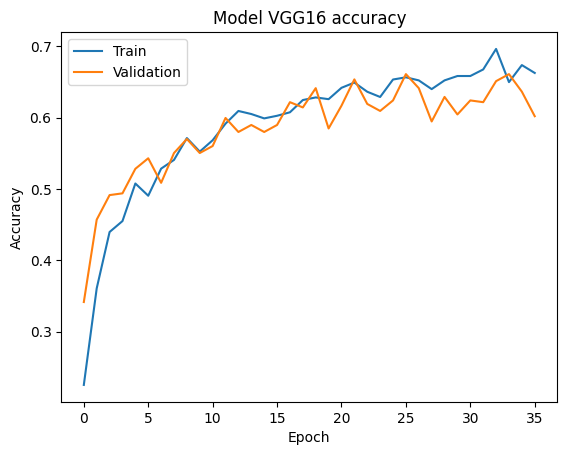

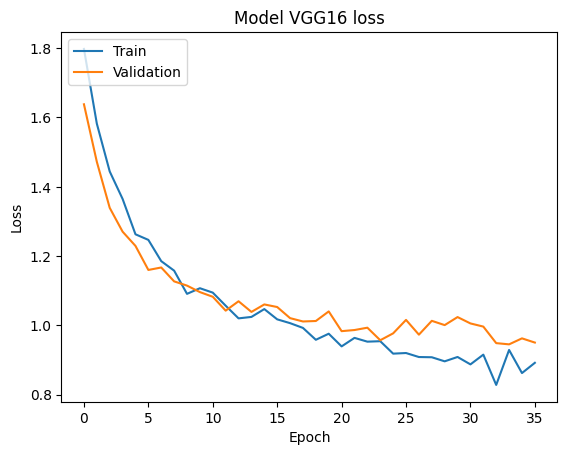

In [28]:
ModelVGG16.evaluate(val_ds)

plt.plot(train_VGG16.history['accuracy'])
plt.plot(train_VGG16.history['val_accuracy'])
plt.title('Model VGG16 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_VGG16.history['loss'])
plt.plot(train_VGG16.history['val_loss'])
plt.title('Model VGG16 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
# # Set environment variable WANDB_API_KEY jika perlu
# os.environ["WANDB_API_KEY"] = "27f45c07393b514104a8305ccd5c903efa8bfb99"

# # Inisialisasi WandB dengan nama organisasi sebagai entity
# wandb.init(project="klasifikasi_trashNet_daniel", entity="danielmrnth12", settings=wandb.Settings(start_method="fork"))


# 5. Evaluasi Model

In [ ]:
# ModelDenseNet201.evaluate(val_ds)

# plt.plot(train_DenseNet201.history['accuracy'])
# plt.plot(train_DenseNet201.history['val_accuracy'])
# plt.title('Model DenseNet201 accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# plt.plot(train_DenseNet201.history['loss'])
# plt.plot(train_DenseNet201.history['val_loss'])
# plt.title('Model DenseNet201 loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

**Simpan Model**

In [ ]:
# ModelDenseNet201.save("AyamDenseNet201-DanielMrnth.h5")
ModelVGG16.save("/content/drive/MyDrive/Amata-ML-Intern/3-TrashNet-VGG16-DanielMrnth.h5")

In [ ]:
# Evaluasi model menggunakan data uji
test_loss, test_acc = ModelVGG16.evaluate(val_ds)

# Log metrik performa ke WandB
wandb.log({
    "Test Accuracy": test_acc,
    "Test Loss": test_loss
})

# Simpan model ke WandB
# ModelVGG16.save("model_trashNet_VGG16.h5")
wandb.save("model_trashNet_VGG16.h5")


## Prediksi gambar

In [ ]:
import matplotlib.image as mpimg
import numpy as np
from io import BytesIO
from IPython.display import Image as IMG
from google.colab import files
from keras.preprocessing import image
from shutil import copyfile

In [ ]:
def PredGambar(file_gmbr, model = ModelDenseNet201):
  file = file_gmbr
  gmbr_array = np.asarray(file)
  gmbr_array = gmbr_array*(1/225)
  gmbr_input = tf.reshape(gmbr_array, shape = [1, 150, 150, 3])

  predik_array = model.predict(gmbr_input)[0]

  df = pd.DataFrame(predik_array)
  df = df.rename({0:'NilaiKemiripan'}, axis = 'columns')
  Kualitas = ['AyamSegar', 'AyamTiren']
  df['Kelas'] = Kualitas
  df = df[['Kelas', 'NilaiKemiripan']]

  predik_kelas = np.argmax(model.predict(gmbr_input))

  if predik_kelas == 0:
    predik_Kualitas = 'AyamSegar'
  else:
    predik_Kualitas = 'AyamTiren'

  return predik_Kualitas, df


In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array




UnggahFile = files.upload()

for n in UnggahFile.keys():
  lok = n
  gmbr = keras.utils.load_img(lok, target_size=(150,150))
  gmbrPlot = plt.imshow(gmbr)
  x = keras.utils.img_to_array(gmbr)
  x = np.expand_dims(x, axis=0)
  gmbr = np.vstack([x])

  kelas, df = PredGambar(gmbr)

  print('\n')
  plt.show()
  print("\nGambar dikenali sebagai " + kelas)
  print('\n')
  print(df)
  print('\n')

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array




UFile = files.upload()

for n in UFile.keys():
  lok = n
  gmbr = keras.utils.load_img(lok, target_size=(150,150))
  gmbrPlot = plt.imshow(gmbr)
  x = keras.utils.img_to_array(gmbr)
  x = np.expand_dims(x, axis=0)
  gmbr = np.vstack([x])

  kelas, df = PredGambar(gmbr)

  print('\n')
  plt.show()
  print("\nGambar dikenali sebagai " + kelas)
  print('\n')
  print(df)
  print('\n')

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array




UngFile = files.upload()

for n in UngFile.keys():
  lok = n
  gmbr = keras.utils.load_img(lok, target_size=(150,150))
  gmbrPlot = plt.imshow(gmbr)
  x = keras.utils.img_to_array(gmbr)
  x = np.expand_dims(x, axis=0)
  gmbr = np.vstack([x])

  kelas, df = PredGambar(gmbr)

  print('\n')
  plt.show()
  print("\nGambar dikenali sebagai " + kelas)
  print('\n')
  print(df)
  print('\n')